### In  this notebook we create and evaluate models using synthetic data

[Creating deformation dataset](#creating-the-deformation-dataset)

[Inference on synthetic data](#inference-using-synthetic-anomalaous-data)

In [1]:
# General imports

import os
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
import h5py
import torch
import re

# ============================================
# Specific imports
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import RegularGridInterpolator

# ============================================
# Helper functions
from helpers import data_bern_numpy_to_preprocessed_hdf5
from helpers import data_bern_numpy_to_hdf5
from helpers.utils import make_dir_safely
from helpers.run import load_model
from helpers.data_loader import load_data
from helpers.metrics import RMSE
from helpers.batches import plot_batch_3d_complete

# ============================================
# Import model
from models.vae import VAE

In [2]:
def generate_noise(batch_size, mean_range = (0, 0.1), std_range = (0, 0.2), n_samples = 30):
    """
    Generates noise to be added to the images
    :param batch_size: number of images in the batch
    :param mean_range: range of means for the normal distribution
    :param std_range: range of standard deviations for the normal distribution
    :return: mean, std, noise
    """
    means = np.random.uniform(mean_range[0], mean_range[1], n_samples)
    stds = np.random.uniform(std_range[0], std_range[1], n_samples)
    #noise_parameters = [(0.0, 0.02), (0.05, 0.05),(0.1, 0.1),(0.1, 0.2),(0.1, 0.3), (0.2, 0.1), (0.2, 0.2) ,(0.2, 0.4), (0.3, 0.1), (0.3, 0.2), (0.3, 0.3)] # additive noise to be tested, each tuple has mean and stdev for the normal distribution

    for (mean, std) in zip(means, stds):

        # Add some random noise to the image
        part_noise = np.random.normal(mean, std, (batch_size, 5, 5, 24, 4))
        full_noise = np.zeros((batch_size, 32, 32, 24, 4))
        full_noise[:, 14:19, 14:19,:, :] = part_noise

        yield mean, std, full_noise

In [3]:
def calc_distance(xyz0 = [], xyz1 = []):
    delta_OX = (xyz0[0] - xyz1[0])**2
    delta_OY = (xyz0[1] - xyz1[1])**2
    delta_OZ = (xyz0[2] - xyz1[2])**2
    return (delta_OX+delta_OY+delta_OZ)**0.5 

def create_mask(im,center,width):
    dims = np.shape(im)
    mask = np.zeros_like(im)
    for i in range(dims[0]):
        for j in range(dims[1]):
            for k in range(dims[2]):
                dist_i = calc_distance([i,j,k],center)
                if dist_i<width:
                    mask[i,j,k]=1
    return mask


def create_deformation(im,center,width,polarity=1):
    dims = np.array(np.shape(im))
    mask = np.zeros_like(im)
    
    center = np.array(center)
    xv,yv,zv = np.arange(dims[0]),np.arange(dims[1]),np.arange(dims[2])
    interp_samp = RegularGridInterpolator((xv, yv, zv), im)
    
    for i in range(dims[0]):
        for j in range(dims[1]):
            for k in range(dims[2]):
                dist_i = calc_distance([i,j,k],center)
                displacement_i = (dist_i/width)**2
                
                if displacement_i < 1.:
                    #within width
                    if polarity > 0:
                        #push outward
                        diff_i = np.array([i,j,k])-center
                        new_coor =  center + diff_i*displacement_i
                        new_coor = np.clip(new_coor,(0,0,0),dims-1)
                        mask[i,j,k]= interp_samp(new_coor)
                        
                    else:
                        #pull inward
                        cur_coor = np.array([i,j,k])
                        diff_i = cur_coor-center
                        new_coor = cur_coor + diff_i*(1-displacement_i)
                        new_coor = np.clip(new_coor,(0,0,0),dims-1)
                        mask[i,j,k]= interp_samp(new_coor)
                else:
                    mask[i,j,k] = im[i,j,k]
    return mask
def create_deformation_chan(im,center,width,polarity=1):
    #print('im shape: ',im.shape)
    dims = np.array(np.shape(im))
    mask = np.zeros_like(im)
    
    center = np.array(center)
    wv,xv,yv,zv = np.arange(dims[0]),np.arange(dims[1]),np.arange(dims[2]),np.arange(dims[3])
    interp_samp = RegularGridInterpolator((wv, xv, yv, zv), im)
    
    for i in range(dims[1]):
        for j in range(dims[2]):
            for k in range(dims[3]):
                dist_i = calc_distance([i,j,k],center)
                displacement_i = (dist_i/width)**2
                
                if displacement_i < 1.:
                    #within width
                    if polarity > 0:
                        #push outward
                        diff_i = np.array([i,j,k])-center
                        new_coor =  center + diff_i*displacement_i
                        
                    else:
                        #pull inward
                        cur_coor = np.array([i,j,k])
                        diff_i = cur_coor-center
                        new_coor = cur_coor + diff_i*(1-displacement_i)
                        
                    new_coor = np.clip(new_coor,np.zeros(len(dims[1:])),dims[1:]-1)
                    new_coor_chan = np.tile(np.arange(dims[0]),(len(dims),1)).T
                    new_coor_chan[:,1:] = new_coor
                    mask[:,i,j,k]= interp_samp(new_coor_chan)
                else:
                    mask[:,i,j,k] = im[:,i,j,k]
    return mask

def generate_deformation_chan(im):
    im2 = copy.deepcopy(im)
    masks = np.zeros_like(im)

    for batch_i in range(im.shape[0]):
        #print('batch_i: ',batch_i)
        im_in = im2[batch_i,:,:,:,:]
        dims = np.array(np.shape(im_in))

        # For the third dimesnion (time) we want the anomalies to be in the start
        core = dims[:3]/[4,4,4] #width of core region
        offset = (dims[:3]-core)/[2,2,18]#offset to center core
        
        """
        core = dims[1:]/4 #width of core region
        offset = (dims[1:]-core)/2#offset to center core
        """
        min_width = np.round(0.05*dims[0])
        max_width = np.round(0.2*dims[0])
        #min_width = 10
        #max_width = 20

        sphere_center = []
        sphere_width = []

        for i,_ in enumerate(dims[:3]):
            sphere_center.append(np.random.randint(offset[i],offset[i]+core[i]))


        sphere_width = np.random.randint(min_width,max_width)
        mask_i = create_mask(im_in,sphere_center,sphere_width)
        #print('sphere_center: ',sphere_center)
        #print('sphere_width: ',sphere_width)
        # Put channels first
        im_in = np.transpose(im_in, (3, 0, 1, 2))
        sphere_polarity = 1
        if np.random.randint(2):#random sign
            sphere_polarity *= -1
        out_image = create_deformation_chan(im_in,sphere_center,sphere_width,sphere_polarity)
        #[c, w, h, t]
        # Put channels last
        out_image = np.transpose(out_image, (1, 2, 3, 0))
        im2[batch_i,:,:,:,:] = out_image
        masks[batch_i,:,:,:,:] = mask_i

    return im2, masks
        
        
        # 
def generate_deformation(im, save_viz=False, subject_idx=0, only_one_channel=False):
    channels_range = range(im.shape[-1])
    if only_one_channel:
        channels_range = [1]
    # Very inneficient way of doing this, but it works
    for batch_i in range(im.shape[0]):
        for channel in channels_range:

            #if channel ==1 and batch_i == 0 and subject_idx ==0:
            #    fig, axs = plt.subplots(3, im.shape[0], figsize=(17, 7))
            #    im_original = im[batch_i,:,:,:,channel].copy()
            im_in = im[batch_i,:,:,:,channel]
            dims = np.array(np.shape(im_in))
            core = dims/4 #width of core region
            offset = (dims-core)/2#offset to center core
            #print('dims: ',dims, ' core: ',core, ' offset: ',offset)

            min_width = np.round(0.05*dims[0])
            max_width = np.round(0.2*dims[0])

            sphere_center = []
            sphere_width = []

            for i,_ in enumerate(dims[:3]):
                sphere_center.append(np.random.randint(offset[i],offset[i]+core[i]))
            sphere_width = np.random.randint(min_width,max_width)
            mask_i = create_mask(im_in,sphere_center,sphere_width)
            sphere_polarity = 1
            if np.random.randint(2):#random sign
                sphere_polarity *= -1
            t = sphere_center[2]
            # Apply deformation
            im[batch_i,:,:,:,channel] = create_deformation(im_in,sphere_center,sphere_width,sphere_polarity)
            """
            if channel == 1 and save_viz and subject_idx == 0:
                
                axs[0, batch_i].imshow(im_original[:,:,t], vmin=-0.5, vmax=0.5)
                axs[0, batch_i].set_title('Original')
                axs[1, batch_i].imshow(mask_i[:,:,t], vmin=-0.5, vmax=0.5)
                axs[1, batch_i].set_title('Mask')
                axs[2, batch_i].imshow(im[batch_i,:,:,:,channel][:,:,t], vmin=-0.5, vmax=0.5)
                axs[2, batch_i].set_title('Deformed')

            """
                
    #if save_viz and subject_idx == 0:
    #    plt.savefig(os.path.join(project_code_root, 'Results/Evaluation/' + config['model'] + '/' + config['preprocess_method'] + '/' + config['model_name'] + '/' + 'deformation_example.png'))
    #    plt.close()
                

    return im, mask_i



### Creating the deformation dataset

Since the deformation applications take time, we instead create a dataset with the deformations and save both the deformed images and the mask

The deformations are done on the two validation images which were not seen during validation or training of the model 

In [4]:
# Data on which we create deformation
data_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/data/'

syn_id_start = 42
syn_id_end = 44
images_syn = h5py.File(data_path + f'val_masked_sliced_images_from_{syn_id_start}_to_{syn_id_end}.hdf5', 'r')['sliced_images_val']
images_syn.shape

(128, 32, 32, 24, 4)

images_to_generate = 30
filepath_out = os.path.join(data_path,f'val_masked_sliced_images_from_{syn_id_start}_to_{syn_id_end}_with_deformations_{images_to_generate}.hdf5')
dataset = {}
hdf5_file = h5py.File(filepath_out, mode='w')
dataset['deformation'] = hdf5_file.create_dataset("deformation", (images_to_generate*64, 32, 32, 24, 4), np.float32)
dataset['mask'] = hdf5_file.create_dataset("mask", (images_to_generate*64, 32, 32, 24, 4), np.float32)

In [8]:
im_in = images_vl[0:2,:,:,:,:]

In [9]:
out_images, masks = generate_deformation_chan(im_in)

In [11]:
out_images.shape

(2, 32, 32, 24, 4)

In [ ]:
set(zip(np.where(masks != 0)[0], np.where(masks != 0)[3]))

{(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5)}

### Inference using synthetic anomalaous data

In [6]:
# Load data
val_id_start = 42
val_id_end = 44

syn_id_start = 42
syn_id_end = 44


images_vl = h5py.File(data_path + f'val_masked_sliced_images_from_{val_id_start}_to_{val_id_end}.hdf5', 'r')['sliced_images_val']
images_syn = h5py.File(data_path + f'val_masked_sliced_images_from_{syn_id_start}_to_{syn_id_end}.hdf5', 'r')['sliced_images_val']
# Load the deformaed images TODO

# This is the data that was used to train the model
val_id_start_tr = 35
val_id_end_tr = 42
images_vl_in_train = h5py.File(data_path + f'val_masked_sliced_images_from_{val_id_start_tr}_to_{val_id_end_tr}.hdf5', 'r')['sliced_images_val']

images_vl.shape, images_syn.shape, images_vl_in_train.shape

((128, 32, 32, 24, 4), (128, 32, 32, 24, 4), (448, 32, 32, 24, 4))

In [7]:
# Parameters
batch_size = 8


x_shape = 32
y_shape = 32
z_shape = 64
t_shape = 24
n_channels = 4

# How many images we want
n_syn_images_wanted = 10

# How many real images we have
n_syn_images = images_syn.shape[0]//z_shape

In [7]:
# Load model

model_name = '20230531-2036_masked_slice_lr5.000e-05-e2000-bs8-zdim2888-daTrue-f100'
model = 'vae'
preprocess_method = "masked_slice"
project_code_root = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/'
latest_model_epoch = 760

model_directory = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/logs/vae/masked_slice/20230531-2036_masked_slice_lr5.000e-05-e2000-bs8-zdim2888-daTrue-f100'
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if model == 'vae':
    print('Loading VAE model')
    match = re.search(r'zdim(\d+)', model_name)
    model = VAE(z_dim=match.group(1), in_channels=4, gf_dim=8).to(device)
    config_model = 'vae'

model_path = os.path.join(project_code_root, model_directory)
model.load_state_dict(torch.load(model_path+'/{}.ckpt-{}'.format(model_name, latest_model_epoch), map_location=device))

Loading VAE model


/scratch_net/biwidl203/lschlyter/anaconda3/envs/vtk_wrap/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


<All keys matched successfully>

# CAREFUL ! FOR THE DEFORMATION the ones that are not attained by anomaly should be added to healthy samples

In [78]:
# Generate synthetic anomalies
noise_generator = generate_noise(batch_size, n_samples= n_syn_images_wanted* z_shape)
anomalous_mean_rmse = []
anomalous_rmse = []
noisy_mean_rmse = []
noisy_rmse = []
healthy_deformation_mean_rmse = []
healthy_deformation_rmse = []
anomalous_deformation_mean_rmse = []
anomalous_deformation_rmse = []
for which_dataset in ['noisy']:
    
    all_dataset_mean_rmse = []
    all_dataset_rmse = []
    for subject in range(n_syn_images_wanted):

        # Since we may have less subjects than images to generate, we need to loop over them
        subject_id = subject% n_syn_images

        # Select subject
        
        subject_sliced = images_syn[subject_id*z_shape:(subject_id+1)*z_shape,:,:,:,:]
        
        start_idx =0
        end_idx = batch_size
        subject_rmse = []
        
        while end_idx <= z_shape:

            # Select slice for batch and run model
            subject_sliced_batch = subject_sliced[start_idx:end_idx,:,:,:,:]

            if which_dataset == 'noisy':
                mean, std, noise = next(noise_generator)
                #print(f'Adding noise with mean {mean} and std {std}')
                subject_sliced_batch += noise
            if which_dataset == 'deformation':
                # TODO: Change this, since the dataset will have been created
                subject_sliced_batch, mask_batch = generate_deformation(subject_sliced_batch, save_viz=False, subject_idx=subject)
                
                
            # Turn into tensor
            subject_sliced_batch = torch.from_numpy(subject_sliced_batch).permute(0,4,1,2,3).to(device)
            # Run model
            model.eval()
            with torch.no_grad():
                
                output_dict  = model(subject_sliced_batch.float())
                reconstruction = output_dict['decoder_output']
                if batch_size !=1:
                    error = RMSE(subject_sliced_batch, reconstruction, dim=(1,2,3))
                subject_rmse.append(error.tolist())     
                out_path = os.path.join(project_code_root,'Results/Evaluation/' + config_model + '/' + preprocess_method + '/' + model_name + '/' + which_dataset + '/' + 'Subject_' + str(subject) + '_' + str(start_idx) + '_' + str(end_idx) + '.png')
                subject_sliced_batch = subject_sliced_batch.transpose(1,2).transpose(2,3).transpose(3,4).cpu().numpy()
                reconstruction = reconstruction.transpose(1,2).transpose(2,3).transpose(3,4).cpu().numpy()
                plot_batch_3d_complete(subject_sliced_batch, reconstruction, every_x_time_step=2, out_path= out_path)

            # Update indices
            start_idx += batch_size
            end_idx += batch_size
        # We have the rmse of the different slices, compute total rmse and std for subject
        subject_rmse = np.array(subject_rmse)
        subject_rmse_mean = np.mean(subject_rmse)
        subject_rmse_std = np.std(subject_rmse)
        print('Subject {} RMSE: {} +/- {}'.format(subject, subject_rmse_mean, subject_rmse_std))
        all_dataset_mean_rmse.append(subject_rmse_mean)
        all_dataset_rmse.append(subject_rmse)
    # End of dataset
    all_dataset_mean_rmse = np.array(all_dataset_mean_rmse)
    all_dataset_rmse = np.array(all_dataset_rmse)
    if which_dataset == 'noisy':
        noisy_mean_rmse.append(all_dataset_mean_rmse)
        noisy_rmse.append(all_dataset_rmse)
    if which_dataset == 'deformation':
        deformation_mean_rmse.append(all_dataset_mean_rmse)
        deformation_rmse.append(all_dataset_rmse)
    dataset_mean_rmse = np.mean(all_dataset_mean_rmse)
    dataset_std_rmse = np.std(all_dataset_mean_rmse)
    anomalous_mean_rmse.append(all_dataset_mean_rmse)
    anomalous_rmse.append(all_dataset_rmse)

anomalous_mean_rmse = np.array(anomalous_mean_rmse).flatten()
anomalous_rmse = np.array(anomalous_rmse).flatten()
noisy_mean_rmse = np.array(noisy_mean_rmse).flatten()
noisy_rmse = np.array(noisy_rmse).flatten()
deformation_mean_rmse = np.array(deformation_mean_rmse).flatten()
deformation_rmse = np.array(deformation_rmse).flatten()
    
print(anomalous_mean_rmse.shape, anomalous_rmse.shape)


Subject 0 RMSE: 0.02547298155544316 +/- 0.008587703690871919
Subject 1 RMSE: 0.02707848359690009 +/- 0.0075947433388965065
Subject 2 RMSE: 0.024460239234485925 +/- 0.007415864705226857
Subject 3 RMSE: 0.026307058355087065 +/- 0.009717184173903758
Subject 4 RMSE: 0.028333293892501388 +/- 0.009004135741618213
Subject 5 RMSE: 0.026357457799349504 +/- 0.008991274323343599
Subject 6 RMSE: 0.028123542708271998 +/- 0.00754419638548879
Subject 7 RMSE: 0.02676526435410172 +/- 0.010708515773805018
Subject 8 RMSE: 0.025953027327280626 +/- 0.008482041880266213
Subject 9 RMSE: 0.02653707037582838 +/- 0.00940637901736046
(10,) (15360,)


In [79]:
noisy_rmse

array([0.03166161, 0.03872396, 0.03857511, ..., 0.01288271, 0.01164797,
       0.01243539])

In [61]:

# Generate synthetic anomalies
noise_generator = generate_noise(batch_size, n_samples= n_syn_images_wanted* z_shape)
sick = []
not_sick = []
anomalous_mean_rmse = []
anomalous_rmse = []
deformation_rmse = []
noisy_mean_rmse = []
noisy_rmse = []
deformation_mean_rmse = []
healthy_deformation_mean_rmse = []
healthy_deformation_rmse = []
anomalous_deformation_mean_rmse = []
anomalous_deformation_rmse = []
all_healthy_deformation_mean_rmse = []
all_healthy_deformation_rmse = []
all_anomalous_deformation_mean_rmse = []
all_anomalous_deformation_rmse = []
for which_dataset in ['deformation']:
    
    all_dataset_mean_rmse = []
    all_dataset_rmse = []
    for subject in range(n_syn_images_wanted):

        # Since we may have less subjects than images to generate, we need to loop over them
        subject_id = subject% n_syn_images

        # Select subject
        
        subject_sliced = images_syn[subject_id*z_shape:(subject_id+1)*z_shape,:,:,:,:]
        
        start_idx =0
        end_idx = batch_size
        subject_rmse = []
        
        while end_idx <= z_shape:

            # Select slice for batch and run model
            subject_sliced_batch = subject_sliced[start_idx:end_idx,:,:,:,:]

            if which_dataset == 'noisy':
                mean, std, noise = next(noise_generator)
                #print(f'Adding noise with mean {mean} and std {std}')
                subject_sliced_batch += noise
            if which_dataset == 'deformation':
                # TODO: Change this, since the dataset will have been created
                subject_sliced_batch, mask_batch = generate_deformation_chan(subject_sliced_batch)
                # Mask with (batch, time) at which there are anomalies
                with_anomalies = set(zip(np.where(mask_batch != 0)[0], np.where(mask_batch != 0)[3]))
                without_anomalies = set(zip(np.where(mask_batch == 0)[0], np.where(mask_batch == 0)[3]))
                
            # Turn into tensor
            subject_sliced_batch = torch.from_numpy(subject_sliced_batch).permute(0,4,1,2,3).to(device)
            # Run model
            model.eval()
            with torch.no_grad():
                
                output_dict  = model(subject_sliced_batch.float())
                reconstruction = output_dict['decoder_output']
                if batch_size !=1 and which_dataset == 'deformation':
                    error = RMSE(subject_sliced_batch, reconstruction, dim=(1,2,3))
                    for anom_coord in with_anomalies:
                        sick.append(error[anom_coord])

                    for normal_coord in without_anomalies - with_anomalies:
                        not_sick.append(error[normal_coord])


                if batch_size !=1 and which_dataset == 'noisy':
                    error = RMSE(subject_sliced_batch, reconstruction, dim=(1,2,3))
                
                #print('error shape: ',error.shape)
                
                subject_rmse.append(error.tolist())     
                out_path = os.path.join(project_code_root,'Results/Evaluation/' + config_model + '/' + preprocess_method + '/' + model_name + '/' + which_dataset + '/' + 'Subject_' + str(subject) + '_' + str(start_idx) + '_' + str(end_idx) + '.png')
                subject_sliced_batch = subject_sliced_batch.transpose(1,2).transpose(2,3).transpose(3,4).cpu().numpy()
                reconstruction = reconstruction.transpose(1,2).transpose(2,3).transpose(3,4).cpu().numpy()
                plot_batch_3d_complete(subject_sliced_batch, reconstruction, every_x_time_step=2, out_path= out_path)

            # Update indices
            start_idx += batch_size
            end_idx += batch_size
        # We have the rmse of the different slices, compute total rmse and std for subject
        all_healthy_deformation_rmse.append(np.array(not_sick))
        all_healthy_deformation_mean_rmse.append(np.mean(np.array(not_sick)))
        all_anomalous_deformation_rmse.append(np.array(sick))
        all_anomalous_deformation_mean_rmse.append(np.mean(np.array(sick)))
        subject_rmse = np.array(subject_rmse)
        subject_rmse_mean = np.mean(subject_rmse)
        subject_rmse_std = np.std(subject_rmse)
        print('Subject {} RMSE: {} +/- {}'.format(subject, subject_rmse_mean, subject_rmse_std))
        all_dataset_mean_rmse.append(subject_rmse_mean)
        all_dataset_rmse.append(subject_rmse)
    # End of dataset
    all_dataset_mean_rmse = np.array(all_dataset_mean_rmse)
    all_dataset_rmse = np.array(all_dataset_rmse)
    healthy_deformation_rmse = all_healthy_deformation_rmse
    healthy_deformation_mean_rmse = all_healthy_deformation_mean_rmse
    anomalous_deformation_rmse = all_anomalous_deformation_rmse
    anomalous_deformation_mean_rmse = all_anomalous_deformation_mean_rmse
    if which_dataset == 'noisy':
        noisy_mean_rmse.append(all_dataset_mean_rmse)
        noisy_rmse.append(all_dataset_rmse)
    if which_dataset == 'deformation':
        deformation_mean_rmse.append(all_dataset_mean_rmse)
        deformation_rmse.append(all_dataset_rmse)
    dataset_mean_rmse = np.mean(all_dataset_mean_rmse)
    dataset_std_rmse = np.std(all_dataset_mean_rmse)
    anomalous_mean_rmse.append(all_dataset_mean_rmse)
    anomalous_rmse.append(all_dataset_rmse)

anomalous_mean_rmse = np.array(anomalous_mean_rmse).flatten()
anomalous_rmse = np.array(anomalous_rmse).flatten()
#noisy_mean_rmse = np.array(noisy_mean_rmse).flatten()
#noisy_rmse = np.array(noisy_rmse).flatten()
deformation_mean_rmse = np.array(deformation_mean_rmse).flatten()
deformation_rmse = np.array(deformation_rmse).flatten()
healthy_deformation_mean_rmse = np.array(healthy_deformation_mean_rmse).flatten()
healthy_deformation_rmse = np.array(healthy_deformation_rmse).flatten()
anomalous_deformation_mean_rmse = np.array(anomalous_deformation_mean_rmse).flatten()
anomalous_deformation_rmse = np.array(anomalous_deformation_rmse).flatten()
    
print(anomalous_mean_rmse.shape, anomalous_rmse.shape, healthy_deformation_mean_rmse.shape, healthy_deformation_rmse.shape, anomalous_deformation_mean_rmse.shape, anomalous_deformation_rmse.shape)


Subject 0 RMSE: 0.01775774235670724 +/- 0.009892845531495631
Subject 1 RMSE: 0.017698558388246965 +/- 0.011193491222940364
Subject 2 RMSE: 0.017818605552027595 +/- 0.009981678320752627
Subject 3 RMSE: 0.0176784101766998 +/- 0.011217478509341265
Subject 4 RMSE: 0.017750370443385084 +/- 0.009703551501620921
Subject 5 RMSE: 0.017654815126358397 +/- 0.011173965871645783
Subject 6 RMSE: 0.017698776615058403 +/- 0.00976062301126429
Subject 7 RMSE: 0.01746511394052656 +/- 0.010715412290777042
Subject 8 RMSE: 0.01792566903880773 +/- 0.009984584563187566
Subject 9 RMSE: 0.017659814420994735 +/- 0.011107295501514501
(10,) (15360,) (10,) (10,) (10,) (10,)


/tmp/ipykernel_23366/4069976726.py:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  healthy_deformation_rmse = np.array(healthy_deformation_rmse).flatten()
/tmp/ipykernel_23366/4069976726.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  anomalous_deformation_rmse = np.array(anomalous_deformation_rmse).flatten()


In [62]:

anomalous_deformation_rmse_final = np.concatenate(anomalous_deformation_rmse.ravel())
healthy_deformation_rmse_final = np.concatenate(healthy_deformation_rmse.ravel())

### For the healthy samples (also unsen during training or validation)

In [63]:
use_val_train = False
if use_val_train:
    val_id_end = val_id_end_tr
    val_id_start = val_id_start_tr
    images_vl = images_vl_in_train
healthy_mean_rmse = []
healthy_rmse = []
all_healthy_mean_rmse = []
all_healthy_rmse = []
for subject in range(val_id_end - val_id_start):
    # Initialize while loop
    start_idx = 0
    end_idx = batch_size
    subject_rmse = []

    # Select subject
    subject_sliced = images_vl[subject*z_shape:(subject+1)*z_shape,:,:,:,:]

    while end_idx <= z_shape:

        # Select slice for batch and run model
        subject_sliced_batch = subject_sliced[start_idx:end_idx,:,:,:,:]
        subject_sliced_batch = torch.from_numpy(subject_sliced_batch).permute(0,4,1,2,3).to(device)
        # Run model
        model.eval()
        with torch.no_grad():
            output_dict  = model(subject_sliced_batch.float())
            reconstruction = output_dict['decoder_output']
            if batch_size !=1:
                error = RMSE(subject_sliced_batch, reconstruction, dim=(1,2,3))
            subject_rmse.append(error.tolist())
            out_path = os.path.join(project_code_root,'Results/Evaluation/' + config_model + '/' + preprocess_method + '/' + model_name + '/' + 'Subject_' + str(subject) + '_' + str(start_idx) + '_' + str(end_idx) + '.png')
            subject_sliced_batch = subject_sliced_batch.transpose(1,2).transpose(2,3).transpose(3,4).cpu().numpy()
            reconstruction = reconstruction.transpose(1,2).transpose(2,3).transpose(3,4).cpu().numpy()
            plot_batch_3d_complete(subject_sliced_batch, reconstruction, every_x_time_step=2, out_path= out_path)

        # Update indices
        start_idx += batch_size
        end_idx += batch_size
    # We have the rmse of the different slices, compute total rmse and std for subject
    subject_rmse = np.array(subject_rmse)
    subject_rmse_mean = np.mean(subject_rmse)
    subject_rmse_std = np.std(subject_rmse)
    print('Subject {} RMSE: {} +/- {}'.format(subject, subject_rmse_mean, subject_rmse_std))
    all_healthy_mean_rmse.append(subject_rmse_mean)
    all_healthy_rmse.append(subject_rmse)
# End of dataset
all_healthy_mean_rmse = np.array(all_healthy_mean_rmse)
all_healthy_rmse = np.array(all_healthy_rmse)
dataset_mean_rmse = np.mean(all_healthy_mean_rmse)
dataset_std_rmse = np.std(all_healthy_mean_rmse)
print('Dataset RMSE: {} +/- {}'.format(dataset_mean_rmse, dataset_std_rmse))
healthy_mean_rmse.append(all_healthy_mean_rmse)
healthy_rmse.append(all_healthy_rmse)

healthy_mean_rmse = np.array(healthy_mean_rmse).flatten()
healthy_rmse = np.array(healthy_rmse).flatten()
    
print(healthy_mean_rmse.shape, healthy_rmse.shape)

Subject 0 RMSE: 0.017096390970588498 +/- 0.008961724243520324
Subject 1 RMSE: 0.016892640507497465 +/- 0.010165691565862767
Dataset RMSE: 0.01699451573904298 +/- 0.00010187523154551667
(2,) (3072,)


In [82]:
anomalous_deformation_rmse_final
healthy_deformation_rmse_final

total_healthy = np.concatenate((healthy_deformation_rmse_final, healthy_rmse))
total_anomalous = np.concatenate((anomalous_deformation_rmse_final, anomalous_rmse))

AUC score: 0.8785718222129504


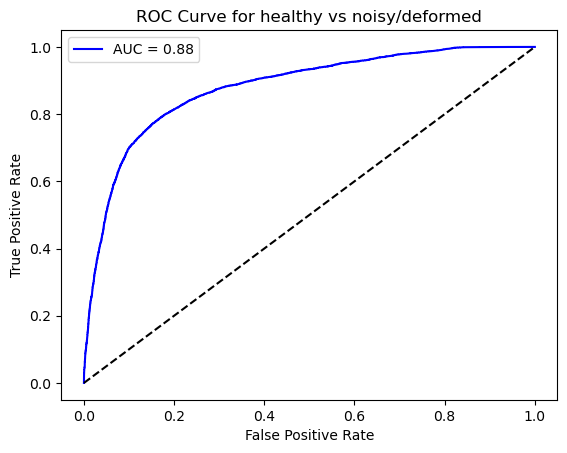

In [83]:
#healthy_mean_rmse = np.concatenate(np.array(healthy_mean_rmse), axis=0)
#anomalous_mean_rmse = np.concatenate(np.array(anomalous_mean_rmse), axis=0)
y_true = np.concatenate((np.zeros(total_healthy.shape), np.ones(total_anomalous.shape)))
y_score = np.concatenate((total_healthy, total_anomalous))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_score = auc(fpr, tpr)
print('AUC score: {}'.format(auc_score))
print('============================================================')
print('============================================================')
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for healthy vs noisy/deformed')
plt.legend()

In [71]:
healthy_rmse

array([0.01603748, 0.01739738, 0.0223995 , ..., 0.00416324, 0.00307341,
       0.00199535])

AUC score: 0.7740100966559516


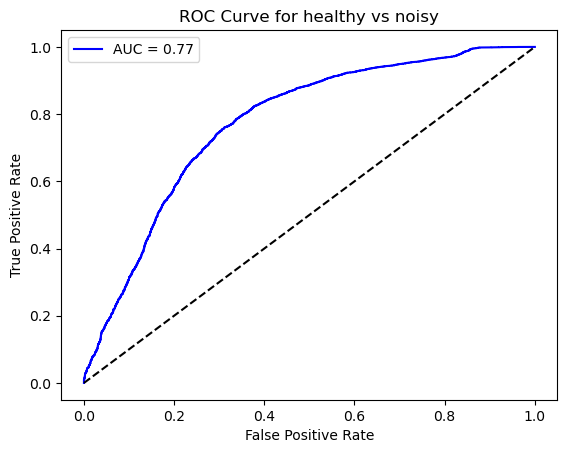

In [81]:

y_true = np.concatenate((np.zeros(np.array(healthy_rmse).shape), np.ones(np.array(noisy_rmse).shape)))
y_score = np.concatenate((np.array(healthy_rmse), np.array(noisy_rmse)))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_score = auc(fpr, tpr)
print('AUC score: {}'.format(auc_score))
print('============================================================')
print('============================================================')
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for healthy vs noisy')
plt.legend()

AUC score: 0.8974708112550699


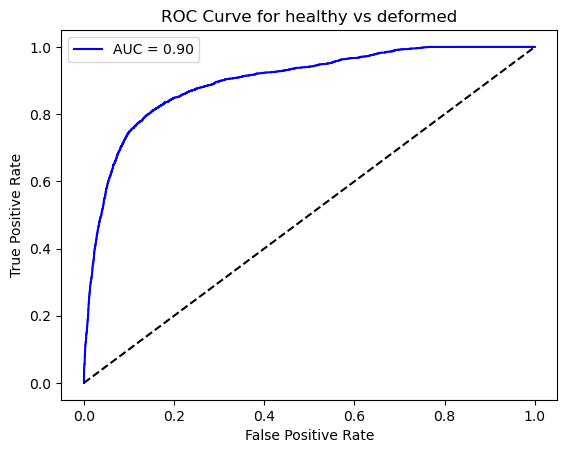

In [73]:

#deformation_mean_rmse = np.concatenate(np.array(deformation_mean_rmse), axis=0)
y_true = np.concatenate((np.zeros(total_healthy.shape), np.ones(anomalous_deformation_rmse_final.shape)))
y_score = np.concatenate((total_healthy, anomalous_deformation_rmse_final))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_score = auc(fpr, tpr)
print('AUC score: {}'.format(auc_score))
print('============================================================')
print('============================================================')
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for healthy vs deformed')
plt.legend()